#### $ conda activate dinov2-semseg
Requires:
torch == 1.12.0a0+2c916ef.nv22.3,
cuda == 11.4,
torchvision == 0.13.0,
mmcv == 1.5.3,
xformers == 0.0.12,
mmseg == 0.27.0

In [1]:
import torch
import torchvision
import mmcv
import xformers
import mmseg
import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torch.version.cuda)
print(torchvision.__version__)
print(mmcv.__version__)
print(xformers.__version__)
print(mmseg.__version__)


/home/jetson/miniforge3/envs/dinov2-semseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jetson/miniforge3/envs/dinov2-semseg/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
Error No module named 'triton'


1.12.0a0+2c916ef.nv22.3
11.4
0.13.0
1.5.3
0.0.12
0.27.0


In [22]:
! nvcc --version
! python --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Sun_Oct_23_22:16:07_PDT_2022
Cuda compilation tools, release 11.4, V11.4.315
Build cuda_11.4.r11.4/compiler.31964100_0
Python 3.8.20


## Utilities

In [10]:
import math
import numpy as np
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.utils.colormaps as colormaps
import dinov2.eval.segmentation.models

DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"

DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}

class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)

## Load pretrained backbone

In [3]:
%%capture
BACKBONE_SIZE = "giant" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

## Load pretrained segmentation head

In [ ]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 5 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "ade20k" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

/home/jetson/miniforge3/envs/dinov2-semseg/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2025-01-26 21:43:49,013 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2025-01-26 21:43:49,022 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([150, 6144, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2025-01-26 21:43:49,023 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([150]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2025-01-26 21:43:49,024 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([6144]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2025-01-26 21:43:49,025 - mmcv - INFO - 
decode_head.bn.bias - t

scales: [1.0, 1.32, 1.73, 2.28, 3.0]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_ms_head.pth


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(6144, 150, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(6144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

## Load sample image

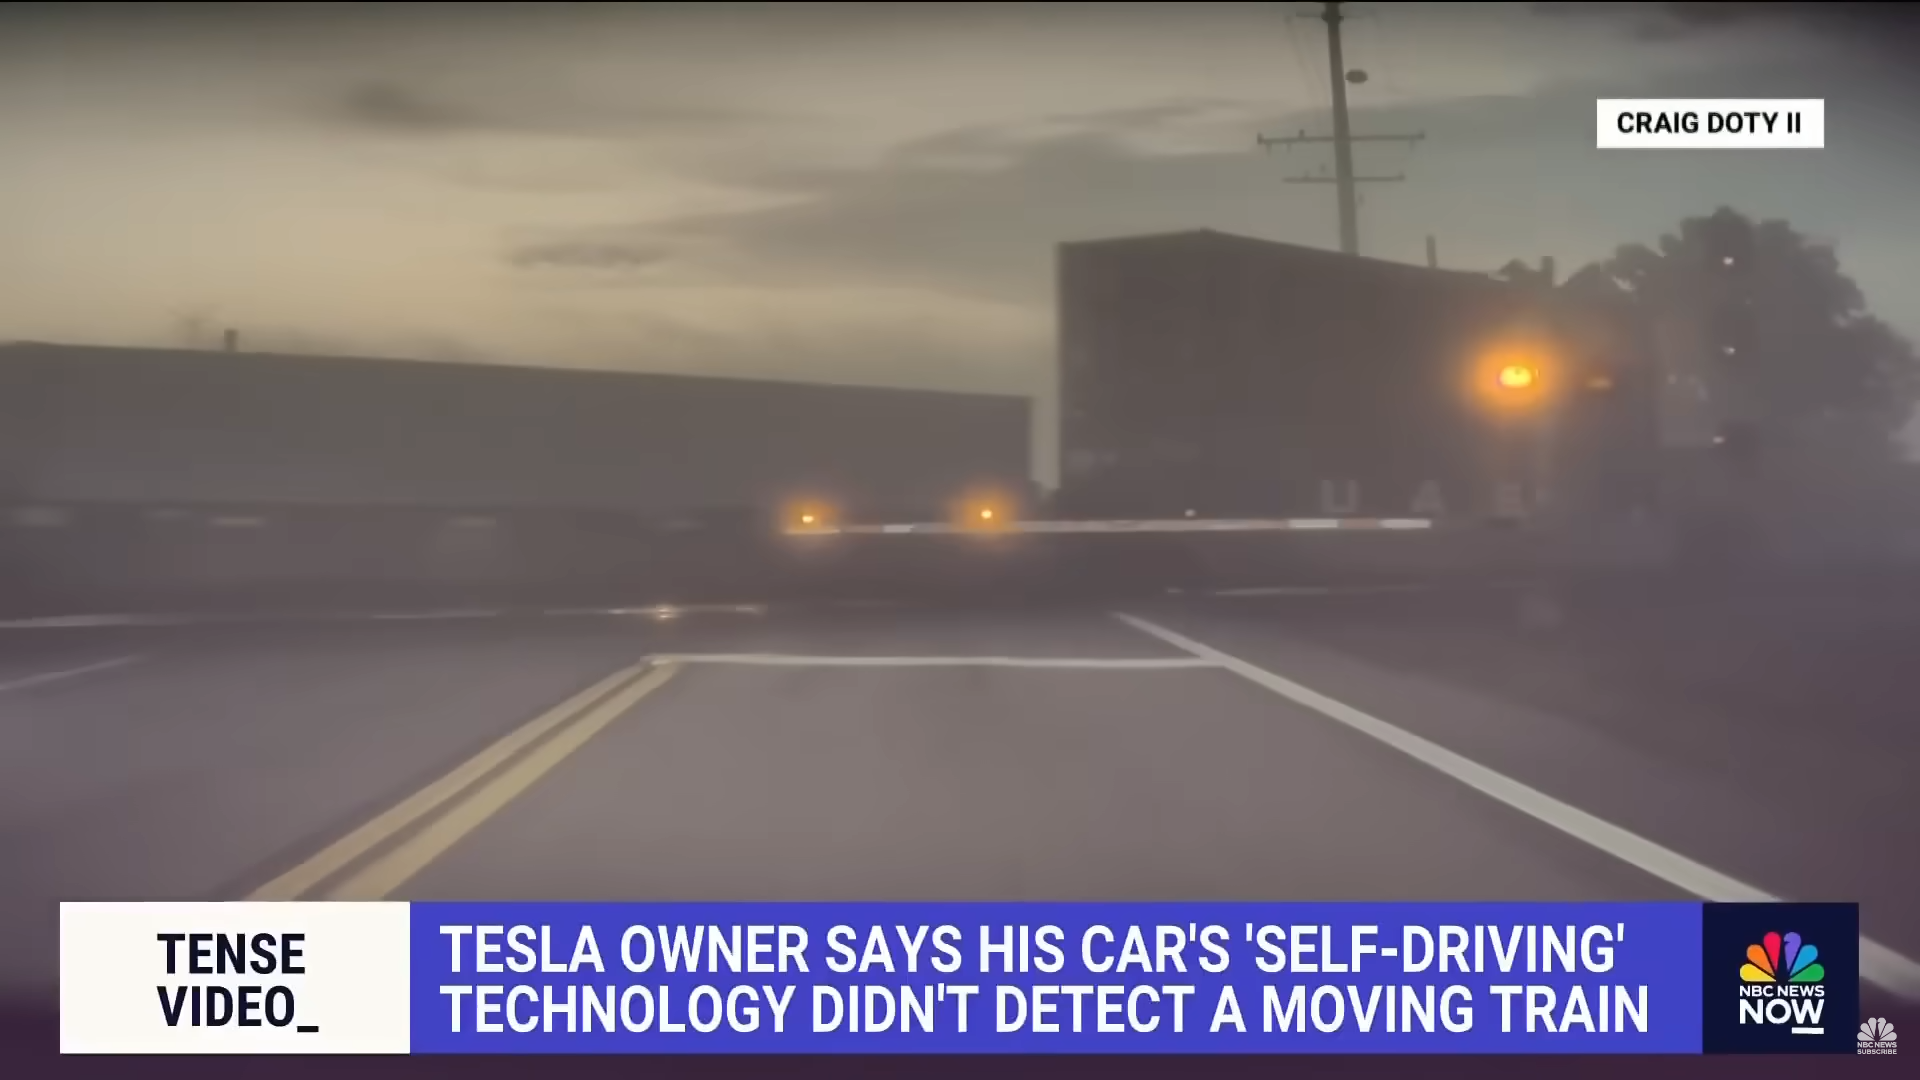

In [6]:
import urllib

from PIL import Image

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

def load_image(url):
  img = Image.open(url).convert("RGB")
  return img

# Images from URL
# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
# EXAMPLE_IMAGE_URL = "http://images.cocodataset.org/val2017/000000005477.jpg"
# image = load_image_from_url(EXAMPLE_IMAGE_URL)

# Local images
image = load_image('./images/Train_close.png')

display(image)

## Semantic segmentation on sample image

In [ ]:
# Segment image
array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

## Load pretrained segmentation model (Mask2Former)

In [8]:
%%capture
import dinov2.eval.segmentation_m2f.models.segmentors

CONFIG_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f_config.py"
CHECKPOINT_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth"

print(CONFIG_URL)
print(CHECKPOINT_URL)

cfg_str = load_config_from_url(CONFIG_URL)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = init_segmentor(cfg)
load_checkpoint(model, CHECKPOINT_URL, map_location="cpu")
model.cuda()
model.eval()

## Semantic segmentation on sample image

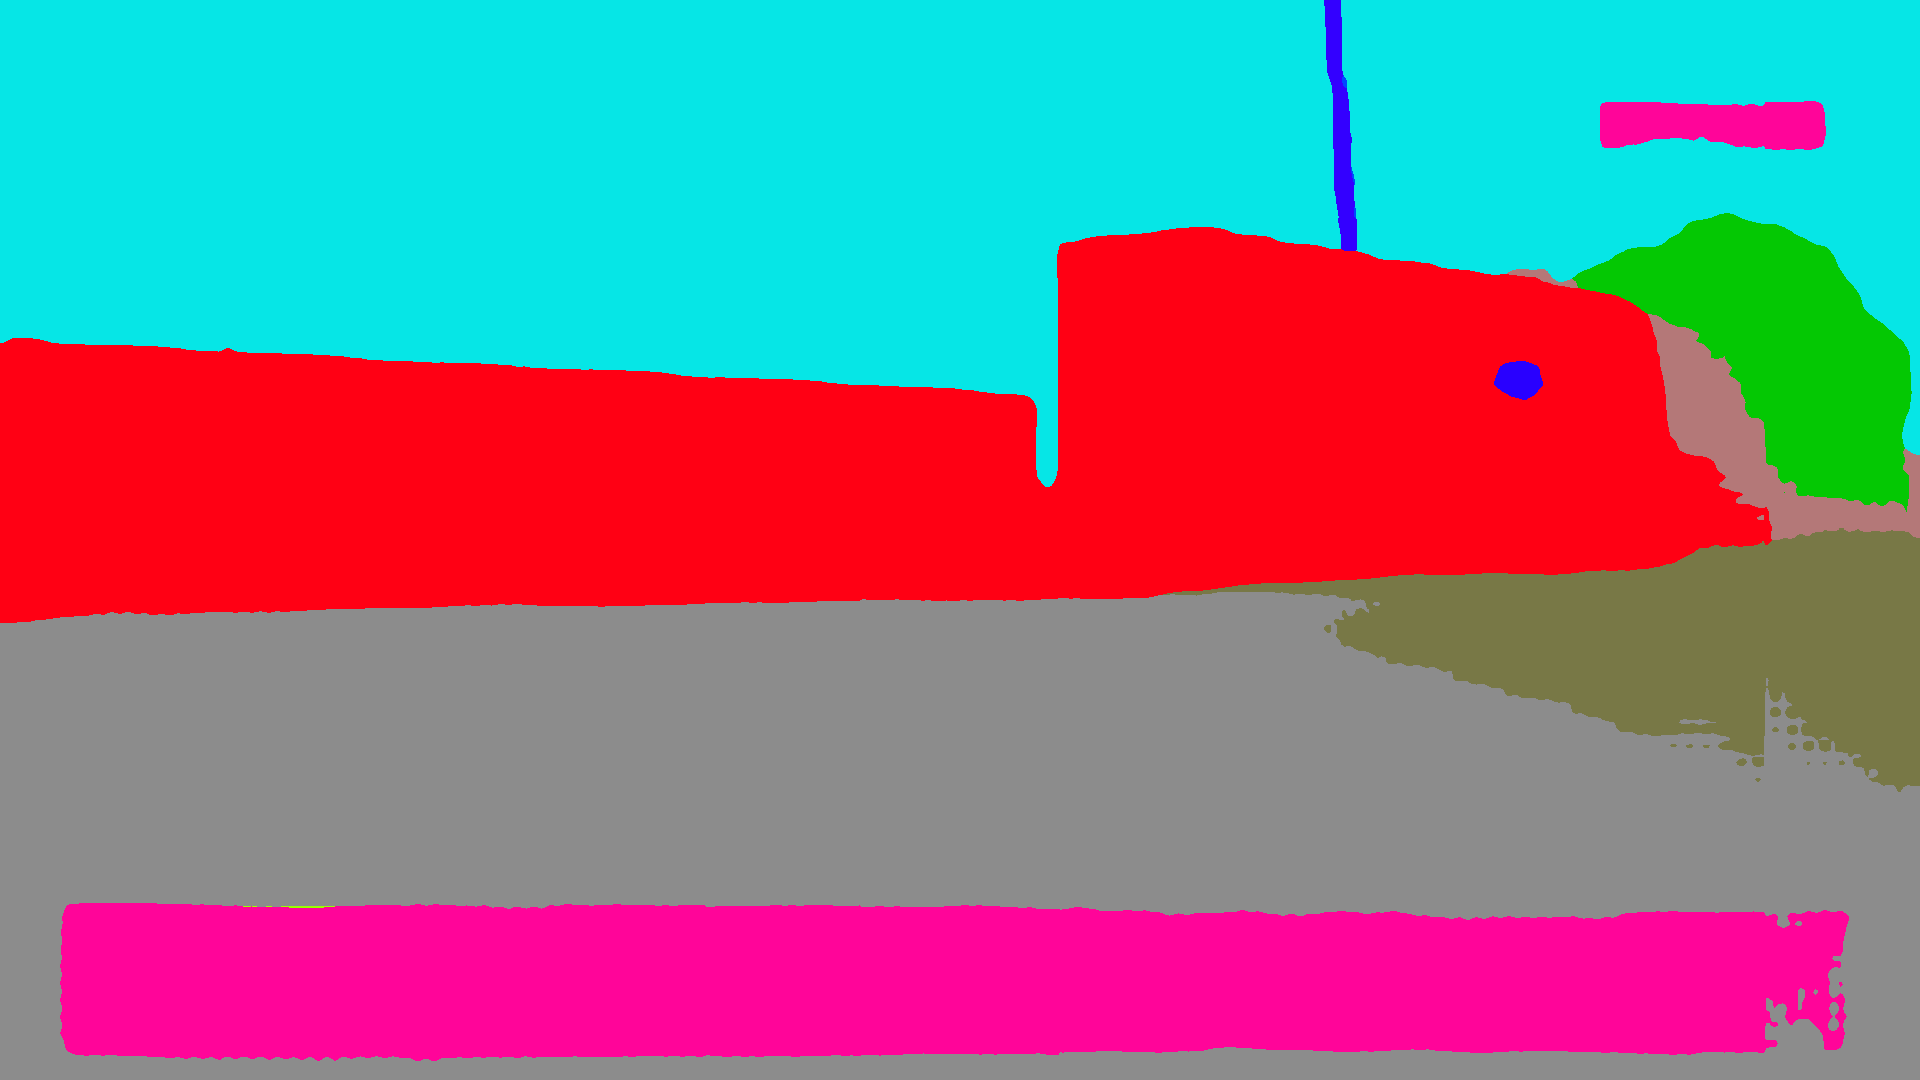

In [11]:
array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")
display(segmented_image)

## Overlay images

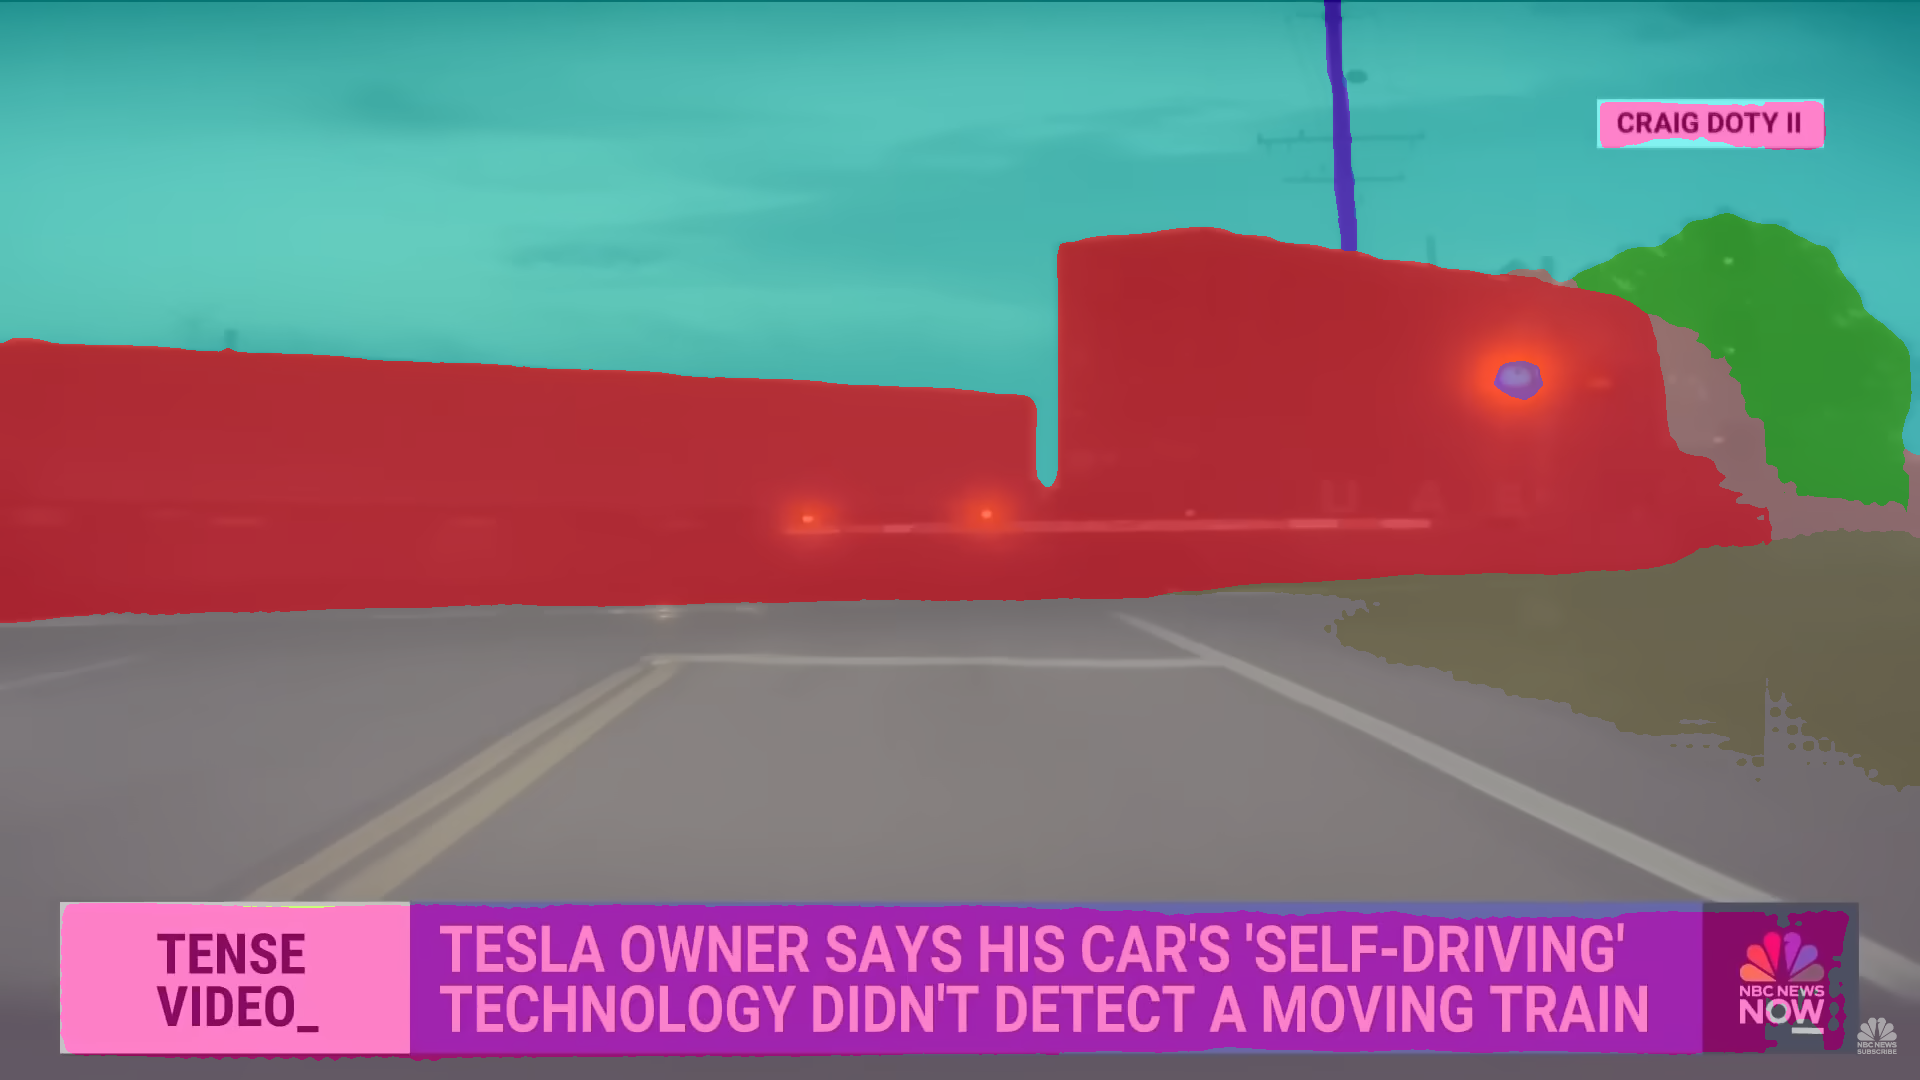

In [12]:
def overlay_images(output_path: str, alpha: float = 0.5):

    # Apply transparency to the segmented image
    output_image = Image.blend(image, segmented_image, alpha)


    display(output_image)
    # Save the resulting image
    # output_image.save(output_path, format='PNG')

# overlay_images("./output.png", 0.5)
overlay_images(None, 0.5)

## Inference on videos


In [ ]:
def overlay_images(output_path: str, alpha: float = 0.5):

    # Apply transparency to the segmented image
    output_image = Image.blend(image, segmented_image, alpha)


    display(output_image)
    # Save the resulting image
    # output_image.save(output_path, format='PNG')


array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")

# overlay_images("./output.png", 0.5)
overlay_images(None, 0.5)

In [14]:
import cv2
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def overlay_images(image, segmented_image, alpha=0.5):
    # Aplica o overlay entre a imagem original e a segmentada.
    return Image.blend(image, segmented_image, alpha)

def process_video(input_video_path, output_dir, alpha=0.5, output_video_path=None, save_frames=True):
    # Certifique-se de que o diretório de saída existe, caso salvar frames seja necessário
    if save_frames:
        os.makedirs(output_dir, exist_ok=True)

    # Abre o vídeo
    cap = cv2.VideoCapture(input_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Configura o vídeo de saída, se necessário
    out_video = None
    if output_video_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    frame_index = 0

    # Loop pelos frames do vídeo
    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="Processando frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Converte o frame para o formato RGB (necessário para PIL)
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # Realiza a inferência
            array = np.array(image)[:, :, ::-1]  # Converte para BGR
            segmentation_logits = inference_segmentor(model, array)[0]

            # Gera a imagem segmentada (renderização já fornecida no seu código)
            segmented_image = render_segmentation(segmentation_logits, "ade20k")

            # Aplica o overlay
            overlayed_image = overlay_images(image, segmented_image, alpha)

            if save_frames:
                # Salva o frame no diretório
                frame_output_path = os.path.join(output_dir, f"frame_{frame_index:06d}.png")
                overlayed_image.save(frame_output_path)

            if output_video_path:
                # Converte o resultado para formato OpenCV e salva no vídeo
                overlayed_frame = cv2.cvtColor(np.array(overlayed_image), cv2.COLOR_RGB2BGR)
                out_video.write(overlayed_frame)

            frame_index += 1
            pbar.update(1)

    # Libera os recursos
    cap.release()
    if out_video:
        out_video.release()

# Configuração de execução
input_video_path = "./videos/video_cityscapes.mp4"  # Caminho para o vídeo de entrada
output_dir = "./images/frames_segmentados"  # Diretório para salvar os frames segmentados
output_video_path = "./videos/video_segmentado.mp4"  # Caminho para o vídeo final (opcional)

# Processa o vídeo (salvar frames ou vídeo, escolha pelo parâmetro output_video_path)
process_video(input_video_path, output_dir, alpha=0.5, output_video_path=output_video_path, save_frames=False)


Processando frames:   0%|          | 0/718 [00:00<?, ?it/s]/home/jetson/Documents/dinov2-jetson/dinov2/eval/segmentation_m2f/models/utils/positional_encoding.py:77: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_feats)
Processando frames: 100%|██████████| 718/718 [1:28:07<00:00,  7.36s/it]
